<h2> Trabalho prático III: Detecção de fraude em cartões de crédito utilizando modelos de classificação.<h2>

<h3> 1. Introdução</h3>

<p> O conjunto de dados selecionado é referente ao histórico de fraudes em cartões de crédito de uma determinada empresa. O objetivo é determinar se alguma atividade do cartão é referente a alguma fraude ou não a partir de modelos de classificação, em seguida, avaliar os resultados.</p>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
%matplotlib inline

df = pd.read_csv("card_transdata.csv", sep = ',')
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


<h3> 2. Limpeza de dados e analise exploratória:</h3>

<h4> 2.2 Checando a existencia de valores nulos</h4>

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


<ul><li>Nâo há valores nulos no dataset</li></ul>

<h4> 2.3 Parametros que só podem ser verdadeiros ou falsos:</h4>

In [3]:
for feature in ['repeat_retailer','used_chip','used_pin_number','online_order','fraud']:
    print(feature,df[feature].unique(),sep=' : ')

repeat_retailer : [1. 0.]
used_chip : [1. 0.]
used_pin_number : [0. 1.]
online_order : [0. 1.]
fraud : [0. 1.]


<h4> 2.3 Verificando outliers</h4>

In [4]:
# Separando features do tipo numerico dos de tipo categóricos
numerical_features = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']
categorical_features =  ['repeat_retailer','used_chip','used_pin_number','online_order','fraud']

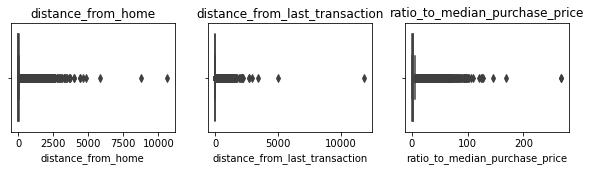

In [5]:
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(10,2))
position_matrix = [0,1,2]

count_var = 0

for feature in numerical_features:
    sns.boxplot(ax=axes[count_var],data=df, x=feature,hue='fraud')
    axes[position_matrix[count_var]].set_title(feature)
    count_var += 1

<ul><li>Por enquanto vamos assumir que os outlier se tratam de fraudes, pois são valores muito altos utilizados a uma distancia muito grande da casa do dono do cartão, portanto não serão removidos</li></ul>

<h4> 2.4 Descrevendo as features do dataset </h4>

<table style = 'float: center'>
<tr>
    <td style = 'text-align:left'>Coluna</td>
    <td style = 'text-align:left'>Descrição</td>
</tr>

<tr>
    <td style = 'text-align:left'> distance_from_home</td>
    <td style = 'text-align:left'> A distancia entre onde foi feita a transação e a casa do dono do cartão (em km)</td>
</tr>
    
<tr>
    <td style = 'text-align:left'> distance_from_last_transaction</td>
    <td style = 'text-align:left'> A distancia entre onde foram feitas a ultima e a atual transação (em Km)</td>
</tr>

<tr>
    <td style = 'text-align:left'> ratio_to_median_purchase_price</td>
    <td style = 'text-align:left'> A razão entre a transação mediana e a transação atual. Expelo: mediana = 50, atual = 60 então "ratio_to_median_purchase_price = 50/60 </td>
</tr>

<tr>
    <td style = 'text-align:left'> repeat_retailer</td>
    <td style = 'text-align:left'> Define se a transação está sendo feita em um lugar onde o cartão é frequentemente utilizado </td>
</tr>

<tr>
    <td style = 'text-align:left'> used_chip</td>
    <td style = 'text-align:left'> Define se a transação foi realizada utilizando um chip RFID</td>
</tr>

<tr>
    <td style = 'text-align:left'> used_pin_number</td>
    <td style = 'text-align:left'> Define se foi utilizado o numero pin na transação</td>
</tr>

<tr>
    <td style = 'text-align:left'> online_order</td>
    <td style = 'text-align:left'> Define se a transação se trata de um pagamento online</td>
</tr>
</table>

<h4> 2.5 Verificando as combinações </h4>

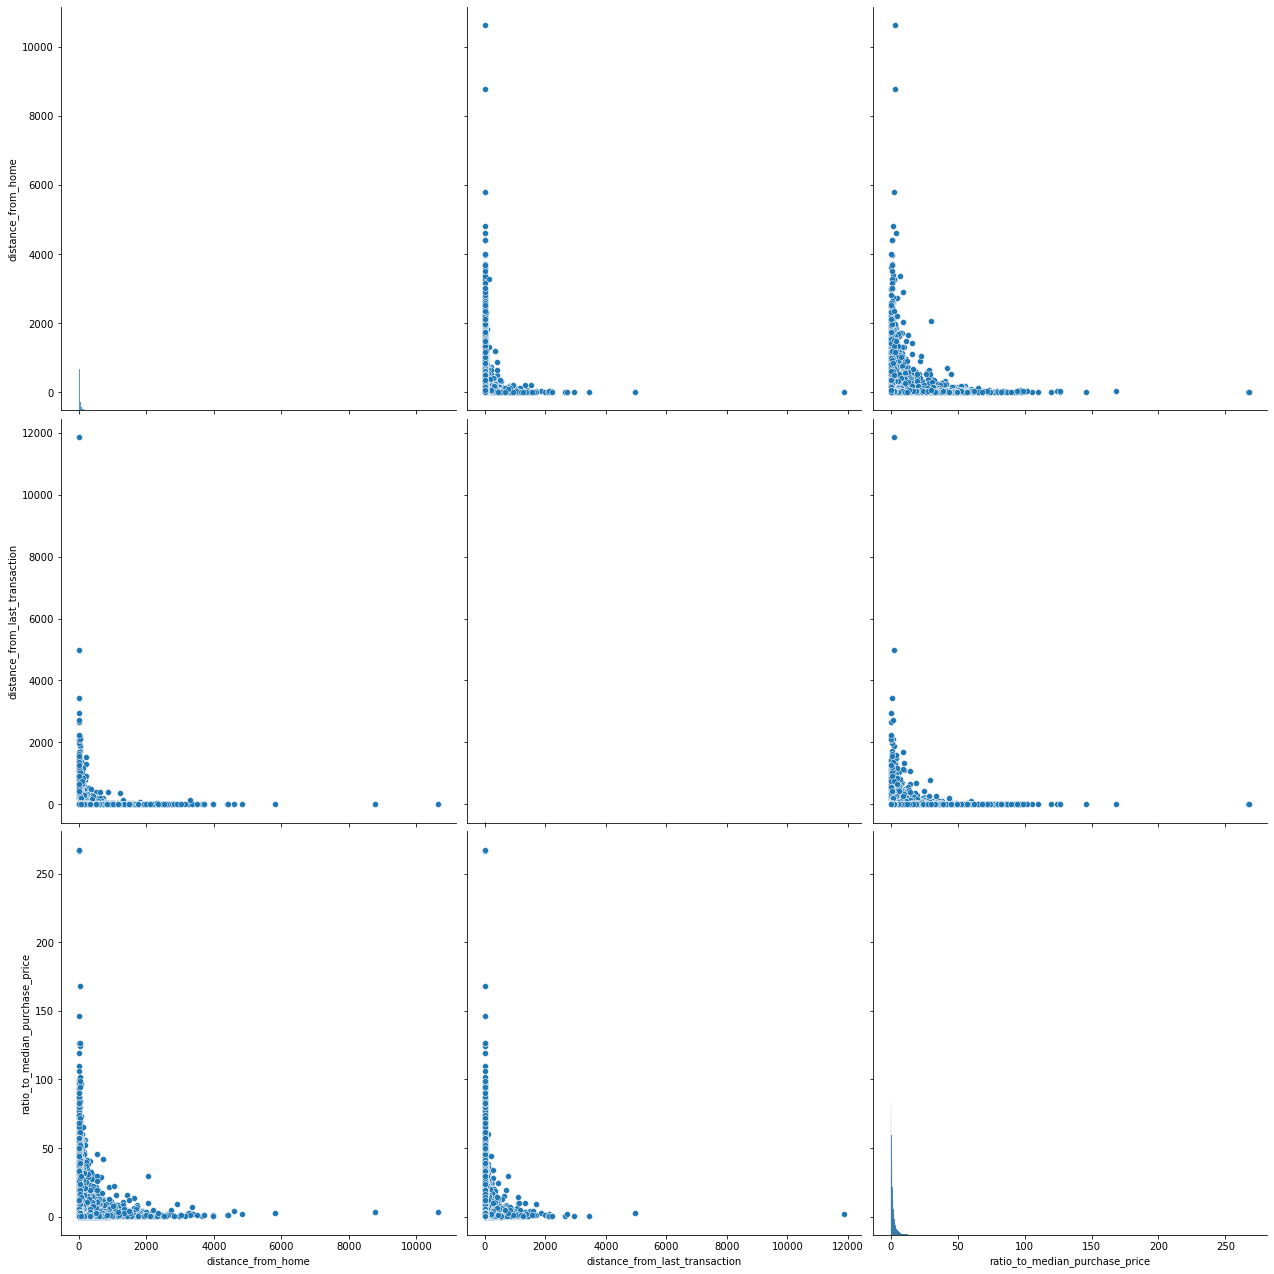

In [8]:
sns.pairplot(data=df[numerical_features], height=6, aspect=1)

<AxesSubplot:xlabel='online_order', ylabel='count'>

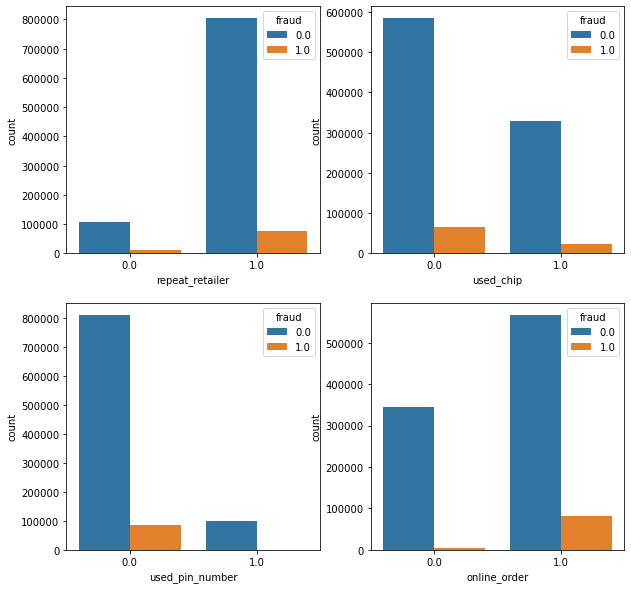

In [9]:
fig, axes = plt.subplots(2, 2, sharex=False, figsize =(10,10))
sns.countplot(ax=axes[0,0],x="repeat_retailer", data=df, hue='fraud')
sns.countplot(ax=axes[0,1],x="used_chip", data=df, hue='fraud')
sns.countplot(ax=axes[1,0],x="used_pin_number", data=df, hue='fraud')
sns.countplot(ax=axes[1,1],x="online_order", data=df, hue='fraud')